# IMDB data set part III: A new dimension in error

To recap, this project has for goal to create a model who predict if a movie will be profitable based on a handful of characteristics like the duration of each movie, their budget, the number of like their cast have on Facebook, etc. To do so, I used the <a href="https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset">IMDB 5000</a> data set created by Kaggle user <a href="https://www.kaggle.com/deepmatrix">deepmatrix</a>, a list of 5000 movies from IMDB and their key statistics. 

In <a href="https://github.com/GTouzin/Portfolio/blob/master/R/IMDB/IMDB_data_cleaning.ipynb">part one</a> of this series of post, I clean this data set and realise that there was a lot of missing information, especially in the key variable budget and gross. In <a href="https://github.com/GTouzin/Portfolio/blob/master/R/IMDB/IMDB_data_cleaning2.ipynb">part two</a> of this series I scape the missing data and continue cleaning the new data set and now, after spending way too much time getting data and cleaning the data set, I can finally look at the distribution of each variable and the relation between them. 

In this blog post, I explored the new IMDB data set and make some hypotheses on the best model to use to predict the profitability of a movie before his production. The first thing I do is to load the R library I'll use in this post and the IMDB data set in the movies data.frame.

In [127]:
library(dplyr)
library(data.table)
library(bit64)
library(plotly)
library(corrplot)
library(tidyr)
options(scipen=999)

In [2]:
movies <- fread("movie_budget_us_2016.csv",stringsAsFactors = F)
head(movies)

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,genres_Sci-Fi,genres_Short,genres_Sport,genres_Thriller,genres_War,genres_Western,currency,budget_us,gross_2016,budget_2016
Color,Joon-ho Bong,363,110,584,74,Kang-ho Song,629,2201412,Comedy|Drama|Horror|Sci-Fi,...,1,0,0,0,0,0,KOR,12793905,2620914.8,15231922
Color,Chan-wook Park,202,112,0,38,Yeong-ae Lee,717,211667,Crime|Drama,...,0,0,0,0,0,0,KOR,4101095,260131.9,5040113
Color,Lajos Koltai,73,134,45,0,PÃ©ter Fancsikai,9,195888,Drama|Romance|War,...,0,0,0,0,1,0,HUN,12526148,240740.0,15394231
Color,Hayao Miyazaki,174,134,6000,745,Jada Pinkett Smith,893,2298191,Adventure|Animation|Fantasy,...,0,0,0,0,0,0,JPN,19836208,3436293.2,29659426
Color,Katsuhiro Ã”tomo,105,103,78,101,Robin Atkin Downes,488,410388,Action|Adventure|Animation|Family|Sci-Fi|Thriller,...,1,0,0,1,0,0,JPN,19664196,521465.0,24986575
Color,Katsuhiro Ã”tomo,150,124,78,4,Takeshi Kusao,6,439162,Action|Animation|Sci-Fi,...,1,0,0,0,0,0,JPN,8583579,891286.1,17420507


Since the categorical variables in the data set are encoded as string of character, I have to code them as factor to do the exploratory analysis.

In [3]:
movies$color<-as.factor(movies$color) 
movies$director_name<-as.factor(movies$director_name)
movies$actor_2_name<-as.factor(movies$actor_2_name)

movies$gross<-as.integer(movies$gross)

movies$actor_1_name<-as.factor(movies$actor_1_name)
movies$actor_3_name<-as.factor(movies$actor_3_name)
movies$language<-as.factor(movies$language)
movies$country<-as.factor(movies$country)
movies$content_rating<-as.factor(movies$content_rating)
movies$aspect_ratio<-as.factor(movies$aspect_ratio)

movies$movie_facebook_likes<-as.integer(movies$movie_facebook_likes)
movies$genres_Action<-as.integer(movies$genres_Action)

Let us look at the distribution of each variable.

# Movie specific statistics

In this section, I will look at the variables describing the movies themselves. In particular, I'll look at the film colorization, their duration, their title, their gross revenue and their budget. 

In [4]:
summary(movies$color)

Black and White           Color 
            201            4616

In [5]:
m = list(
  l = 50,
  r = 0,
  b = 50,
  t = 30,
  pad = 0
) 

hist_color <- plot_ly(movies[complete.cases(movies$color),],x=~color,color=~color,type="histogram") %>%
layout(title = 'Proprotion of each film colorization in the IMDB data set',
         xaxis = list(title = 'Color of movies', zeroline = TRUE),
         yaxis = list(title = 'Frequency',range = c(0,5000)),
         margin=m)
embed_notebook(hist_color,file=paste0("plotlyJupyterHTML/","hist_color",".html"))

Warning message in RColorBrewer::brewer.pal(N, "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

I'm interested to see how the colorization of movies changes over the years for the movie in the data set. 

In [6]:
movies_decade<-movies[,c("title_year","color"),with=FALSE]

In [7]:
decade<-function(x){
    d<-as.double(x)
    
    return ((floor(d/10))*10)
}

In [8]:
movies_decade$decades<-decade(movies_decade$title_year)
head(movies_decade$decades)

[1] 2000 2000 2000 1990 2000 1980

In [9]:
hist_color_decade <- movies_decade %>%
  dplyr::count(color,decades) %>%
  plot_ly(x =~decades, y = ~n,color=~color) %>% 
  add_bars()%>%
layout(title = 'Film colorization in the IMDB data set by decade',
         xaxis = list(title = 'Color of movies', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_color_decade,file=paste0("plotlyJupyterHTML/","hist_color_decade",".html"))

Warning message:
"Ignoring 1 observations"Warning message in RColorBrewer::brewer.pal(N, "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

The number of color movie grown decade from decade, but the number of black and white movie stay almost the same. In consequence their relative frequency must go down each year. Let us look at the relative frequency of both color and black and white movies in the data set.

In [10]:
freq_color_year<-movies_decade %>%
group_by(title_year,color) %>%
tally%>%
mutate(freq=n/sum(n))

In [11]:
levels(freq_color_year$color)[levels(freq_color_year$color)=="Black and White"]<-"BW"
head(freq_color_year)

title_year,color,n,freq
1916,BW,1,1
1920,BW,1,1
1925,BW,1,1
1927,BW,1,1
1929,BW,2,1
1930,BW,1,1


In [12]:
freq_color_year$title_year<-as.integer(freq_color_year$title_year)

In [13]:
freq_color_spread<-spread(freq_color_year,color,value=freq)
head(freq_color_spread,n=5)

title_year,n,BW,Color
1916,1,1,NA
1920,1,1,NA
1925,1,1,NA
1927,1,1,NA
1929,2,1,NA


In [14]:
plot_color_freq<-plot_ly(freq_color_spread, x = ~title_year) %>%
add_trace(y=~BW,name = 'trace 0', type = 'scatter',mode = 'lines+markers' )%>%
add_trace(y=~Color,name = 'trace 1', type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Trend line of the proportion ofmovie\'s color in the IMDB data set over the year',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Relative frequency'))

embed_notebook(plot_color_freq,file=paste0("plotlyJupyterHTML/","plot_color_freq",".html"))

We can see that the number of movies in black and white stay stable over time, but the overall number of movies grows so much that their relative frequency is almost zero near the 90's.

Now I take a look at the "duration" variable.

In [15]:
summary(movies$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    7.0    94.0   104.0   108.1   118.0   334.0      13 

In [16]:
hist_duration <- plot_ly(x=~movies$duration,type="histogram")%>%
layout(title = 'Length of the movies in the IMDB data set',
         xaxis = list(title = 'Duration of movie', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_duration,file=paste0("plotlyJupyterHTML/","hist_duration",".html"))

Warning message:
"Ignoring 13 observations"

There seem's to be some outlier in the data. By drawing a box plot, I can easily find the value that are out of the norm.

In [17]:
box_duration <- plot_ly(x=~movies$duration[complete.cases(movies$duration)],type="box")%>%
layout(title = 'Distribution of the length of the movies in the IMDB data set',
         xaxis = list(title = 'Duration of movie', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(box_duration,file=paste0("plotlyJupyterHTML/","box_duration",".html"))

In [18]:
movies[duration<59,movie_imdb_link]

[1] "http://www.imdb.com/title/tt0920458/?ref_=fn_tt_tt_1"
 [2] "http://www.imdb.com/title/tt0245280/?ref_=fn_tt_tt_1"
 [3] "http://www.imdb.com/title/tt4061848/?ref_=fn_tt_tt_1"
 [4] "http://www.imdb.com/title/tt0996382/?ref_=fn_tt_tt_1"
 [5] "http://www.imdb.com/title/tt1529567/?ref_=fn_tt_tt_1"
 [6] "http://www.imdb.com/title/tt0092991/?ref_=fn_tt_tt_1"
 [7] "http://www.imdb.com/title/tt0473107/?ref_=fn_tt_tt_1"
 [8] "http://www.imdb.com/title/tt0854678/?ref_=fn_tt_tt_1"
 [9] "http://www.imdb.com/title/tt4273494/?ref_=fn_tt_tt_1"
[10] "http://www.imdb.com/title/tt0059026/?ref_=fn_tt_tt_1"
[11] "http://www.imdb.com/title/tt0478988/?ref_=fn_tt_tt_1"
[12] "http://www.imdb.com/title/tt0283465/?ref_=fn_tt_tt_1"
[13] "http://www.imdb.com/title/tt1128219/?ref_=fn_tt_tt_1"
[14] "http://www.imdb.com/title/tt1869849/?ref_=fn_tt_tt_1"
[15] "http://www.imdb.com/title/tt0092337/?ref_=fn_tt_tt_1"
[16] "http://www.imdb.com/title/tt2164708/?ref_=fn_tt_tt_1"
[17] "http://www.imdb.com/title/tt1003002/?ref_=fn_tt_tt_1"

Looking at the IMDB page of the observations with a strangely short duration, I found out that most of them are either short film, small documentary or mini series who had theater release. In those cases, the episode running time is often written in the running time of the theatrical cut which case the difference in time. Since the number of problematic observation is really small, I won't change the data set. 

Now, I look at movie who are suspiciously long. The box-plot tell us that movie with a length of more than 154 is out of the norm, but a lot of movies these days last more than 200 minutes. In consequence, I'll look at movie who are longer than 200 minutes to see for outlier.

In [19]:
movies[duration>200&duration<300,movie_imdb_link]

[1] "http://www.imdb.com/title/tt0360717/?ref_=fn_tt_tt_1"
 [2] "http://www.imdb.com/title/tt0346491/?ref_=fn_tt_tt_1"
 [3] "http://www.imdb.com/title/tt0409459/?ref_=fn_tt_tt_1"
 [4] "http://www.imdb.com/title/tt0993846/?ref_=fn_tt_tt_1"
 [5] "http://www.imdb.com/title/tt0217505/?ref_=fn_tt_tt_1"
 [6] "http://www.imdb.com/title/tt0111756/?ref_=fn_tt_tt_1"
 [7] "http://www.imdb.com/title/tt0149624/?ref_=fn_tt_tt_1"
 [8] "http://www.imdb.com/title/tt0279111/?ref_=fn_tt_tt_1"
 [9] "http://www.imdb.com/title/tt0120863/?ref_=fn_tt_tt_1"
[10] "http://www.imdb.com/title/tt0113987/?ref_=fn_tt_tt_1"
[11] "http://www.imdb.com/title/tt0102138/?ref_=fn_tt_tt_1"
[12] "http://www.imdb.com/title/tt0104797/?ref_=fn_tt_tt_1"
[13] "http://www.imdb.com/title/tt0078788/?ref_=fn_tt_tt_1"
[14] "http://www.imdb.com/title/tt0056937/?ref_=fn_tt_tt_1"
[15] "http://www.imdb.com/title/tt0087843/?ref_=fn_tt_tt_1"
[16] "http://www.imdb.com/title/tt0107007/?ref_=fn_tt_tt_1"
[17] "http://www.imdb.com/title/tt0837106/?ref_=fn_tt_tt_1"
[18] "http://www.imdb.com/title/tt0093389/?ref_=fn_tt_tt_1"
[19] "http://www.imdb.com/title/tt0083987/?ref_=fn_tt_tt_1"
[20] "http://www.imdb.com/title/tt0099348/?ref_=fn_tt_tt_1"
[21] "http://www.imdb.com/title/tt0059245/?ref_=fn_tt_tt_1"
[22] "http://www.imdb.com/title/tt0056172/?ref_=fn_tt_tt_1"
[23] "http://www.imdb.com/title/tt0082096/?ref_=fn_tt_tt_1"
[24] "http://www.imdb.com/title/tt0071562/?ref_=fn_tt_tt_1"
[25] "http://www.imdb.com/title/tt0031381/?ref_=fn_tt_tt_1"
[26] "http://www.imdb.com/title/tt0047478/?ref_=fn_tt_tt_1"
[27] "http://www.imdb.com/title/tt0066580/?ref_=fn_tt_tt_1"

I looked at the IMDB page of the majority of those movies and all the durations seems correct. The only thing that could add some variability in the model is the fact that some movie has multiple cuts and it is impossible to know if the value of the duration of the data set is the one of the cut that made it in the majority of the theater.

After that, I looked at the variable "movie_title". First of all, I'm interested to know the distribution of the number of letters in the title of the movies.

In [20]:
title_length<-data.frame("Title"=movies$movie_title,"Length"=nchar(movies$movie_title),"Gross"=movies$gross)
head(title_length)

Title,Length,Gross
thehost,7,2201412
ladyvengeance,13,211667
fateless,8,195888
princessmononoke,16,2298191
steamboy,8,410388
akira,5,439162


In [21]:
hist_length <- title_length %>%
  dplyr::count(Length) %>%
  plot_ly(x =~Length, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of movie\'s title length in the IMDB data set',
         xaxis = list(title = 'Length of the movies title', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_length,file=paste0("plotlyJupyterHTML/","hist_length",".html"))

Here again, there seem's to be some outlier in the data and to make sure those are not error in the data set, I looked at the longest movie title.

In [22]:
head(title_length[order(-title_length$Length),],n=10)

,Title,Length,Gross
3845,30nightsofparanormalactivitywiththedevilinsidethegirlwiththedragontattoo,72,0
2310,boratculturallearningsofamericaformakebenefitgloriousnationofkazakhstan,71,128505958
4132,the41yearoldvirginwhoknockedupsarahmarshallandfeltsuperbadaboutit,65,NA
3967,everythingyoualwayswantedtoknowaboutsexbutwereafraidtoask,57,NA
4040,drstrangeloveorhowilearnedtostopworryingandlovethebomb,54,NA
4226,onceinalifetimetheextraordinarystoryofthenewyorkcosmos,54,144431
78,thechroniclesofnarniathelionthewitchandthewardrobe,50,291709845
1645,theassassinationofjessejamesbythecowardrobertford,49,3904982
4371,deceptivepracticethemysteriesandmentorsofrickyjay,49,151389
1709,alexanderandtheterriblehorriblenogoodverybadday,47,66950483


I learn two things by Googling those movies: first they are all legit movie, there was no error in the data set; second some porno producers like to concatenate the name of popular movies and use that as the name for their movie, probably to maximize their google ranking. Well, I knew I'll learn something by analysing that data set!

I'm interested to know if the length of a movie influence his performance at the box-office.

In [23]:
temp<-title_length[!is.na(title_length$Gross),]
fit <- lm(Gross ~ Length, data = temp)
scat_title_gross<-plot_ly(temp,x=~Length,y=~Gross, type="scatter", mode = "markers")%>% 
add_markers(color=~Gross, alpha = 0.4)%>% 
add_trace(data=temp,x = ~Length, y = ~fitted(fit), mode = "lines")

embed_notebook(scat_title_gross,file=paste0("plotlyJupyterHTML/","scat_title_gross",".html"))

We can see from this plot that the length of a movie title has a small effect on the box-office revenue of a movie. 

Next: I analyse at the "facenumber_in_poster" variable. This variable is an attempt to quantify the phenomenon of "the giant floating head" seen in a lot of movie posters like this one:<img src="image/ghost_rider.jpg">

or this one:<img src="image/scream_2.jpg">

or those :<img src="image/Movie-Posters-That-Look-Similar-13.jpg" style="width:50%">

As you can see, it's an overuse poster style.

In [24]:
summary(movies$facenumber_in_poster)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   1.000   1.368   2.000  43.000      13 

In [25]:
scat_title_gross<-movies[complete.cases(movies$facenumber_in_poster),]%>% 
  dplyr::count(facenumber_in_poster) %>%
  plot_ly(x =~facenumber_in_poster, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Number of faces on the movie poster',
         xaxis = list(title = 'Number of faces', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(scat_title_gross,file=paste0("plotlyJupyterHTML/","scat_title_gross",".html"))

The maximal value taken by this variable is 43, which is quite high. Since the number of heads in each poster has been counted by a face recognition algorithm, I suspect that this is an aberrant value. If that's not the case, investigating these data is worth my time just to find what kind of abomination of a poster can contain that many heads.

In [26]:
faaaaaaaaaaace<-data.table(movie_title=movies$movie_title,facenumber=movies$facenumber)
faaaaaaaaaaace<-faaaaaaaaaaace[order(-movies$facenumber)]
head(faaaaaaaaaaace, n=10)

movie_title,facenumber
500daysofsummer,43
themaster,31
battleoftheyear,19
theexpendables3,15
newyearseve,15
cheaperbythedozen,15
asitisinheaven,15
boogienights,15
shouldvebeenromeo,15
abridgetoofar,14


Mother of God: the movies "500 Days of Summer" poster really has 43 faces on it! 
<img src="image/500_days_of_summer.jpg" style="width:50%">

I also looked at 10 movies who have the most heads on their poster and the face recognition algorithm was on mark. As an exemple, here's the poster of "The master" movie: <img src="image/The_master.jpg" style="width:50%">

I conclude that there's no outlier in those data, just marketing executive that pushed the concept of the giant floating head too far.

After looking at the number of faces in each movie poster, focused on the genre of the movie, in particular the average gross revenue by genre.

In [27]:
colnames(movies)<-sub("-", "_", colnames(movies))

In [28]:
col_genre<-c("genres_Action", "genres_Adventure", "genres_Animation", "genres_Biography", "genres_Comedy", "genres_Crime",
"genres_Documentary", "genres_Drama", "genres_Family", "genres_Fantasy", "genres_Film_Noir", 
 "genres_History", "genres_Horror", "genres_Music", "genres_Musical", "genres_Mystery","genres_News",
"genres_Romance", "genres_Sci_Fi","genres_Short", "genres_Sport","genres_Thriller","genres_War","genres_Western", "gross")

genre_gross<-movies[,col_genre,with=FALSE]

In [29]:
count_genre_gross<-sapply(genre_gross[,!25], function(x)sum(as.numeric(x),na.rm=TRUE))
sum_genre_gross<-sapply(genre_gross[,!25], function(x)sum(as.numeric(x)*as.numeric(genre_gross$gross),na.rm=TRUE))
stat_genre_gross<-data.frame(Count=count_genre_gross,Sum=sum_genre_gross)

In [30]:
stat_genre_gross$Mean<-as.numeric(stat_genre_gross$Sum/stat_genre_gross$Count)
stat_genre_gross$Name<-as.character(col_genre[1:24])
head(stat_genre_gross)

,Count,Sum,Mean,Name
genres_Action,1094,71844560555,65671445,genres_Action
genres_Adventure,877,75440686524,86021307,genres_Adventure
genres_Animation,233,21483583536,92204221,genres_Animation
genres_Biography,290,9143454008,31529152,genres_Biography
genres_Comedy,1813,76749009842,42332603,genres_Comedy
genres_Crime,838,27723849524,33083353,genres_Crime


In [31]:
stat_genre_gross$Name<-substr(stat_genre_gross$Name,8,nchar(stat_genre_gross$Name))

In [32]:
m = list(
  l = 50,
  r = 0,
  b = 50,
  t = 30,
  pad = 0
) 
hist_genre<-plot_ly(stat_genre_gross,x=~Name,y=~Mean)%>% 
    add_bars()%>%
    layout(title = 'Mean gross by genre',
             xaxis = list(title = ''),
             yaxis = list(title = 'Total gross'),
         margin=m)

embed_notebook(hist_genre,file=paste0("plotlyJupyterHTML/","hist_genre",".html"))

The histogram suggests that the genre of movie influences significantly the gross revenue of a movie. Also, this plot gives me some insight on why I can't find a good film-noir to watch on a rainy Monday night: they make as much money than short movie. Sad.

After looking at the genre of a movie, I look at the distribution of the language used in the movie data set.

In [33]:
summary(movies$language,maxsum=10)

English    French   Spanish     Hindi  Mandarin    German  Japanese Cantonese 
     4488        72        40        28        24        19        16        11 
  (Other)      NA's 
      108        11

In [34]:
m = list(
  l = 50,
  r = 0,
  b = 100,
  t = 30,
  pad = 0
) 
hist_lg<-movies[complete.cases(movies$language),]%>% 
  dplyr::count(language) %>%
  plot_ly(x =~language, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Language used in the movies from the IMDB data set',
         xaxis = list(title = 'Language', zeroline = TRUE),
         yaxis = list(title = 'Frequency'),
         margin=m)

embed_notebook(hist_lg,file=paste0("plotlyJupyterHTML/","hist_lg",".html"))

There's so many movies of English language in the data set, that this graph is not really useful. Let's remove those movies from the set and draw the histogram of the non-English movies. 

In [35]:
hist_lg_english_out<-movies[language!="English"]%>% 
  dplyr::count(language) %>%
  plot_ly(x =~language, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Non english language used in the movies from the IMDB data set',
         xaxis = list(title = 'Language', zeroline = TRUE),
         yaxis = list(title = 'Frequency'),
         margin=m)

embed_notebook(hist_lg_english_out,file=paste0("plotlyJupyterHTML/","hist_lg_english_out",".html"))

So the French, Spanish and Hindi are the most use language apart English in the data set. All and all, they represent a negligible amount of movie in the data set.

Let us look at the country of production of each movie.

In [36]:
summary(movies$country,maxsum=10)

USA        UK    France    Canada   Germany Australia     India     Spain 
     3637       420       153       121        94        51        34        33 
  (Other)      NA's 
      271         3

In [38]:
hist_country1<-movies%>% 
  dplyr::count(country) %>%
  plot_ly(x =~country[1:25], y = ~n[1:25]) %>% 
  add_bars()%>%
layout(title = 'Country of origin of the movies from the IMDB data set',
         xaxis = list(title = 'Country'),
         yaxis = list(title = 'Frequency'),
         margin=m)

embed_notebook(hist_country1,file=paste0("plotlyJupyterHTML/","hist_country",".html"))

m = list(
  l = 50,
  r = 0,
  b = 120,
  t = 30,
  pad = 0
) 
hist_country2<-movies%>% 
  dplyr::count(country) %>%
  plot_ly(x =~country[26:65], y = ~n[26:65]) %>% 
  add_bars()%>%
layout(title = 'Country of origin of the movies from the IMDB data set',
         xaxis = list(title = 'Country'),
         yaxis = list(title = 'Frequency'),
         margin=m)

embed_notebook(hist_country2,file=paste0("plotlyJupyterHTML/","hist_country",".html"))

Again, the American movie represents the vast majority of the movie in the data set. Without them, we get this histogram.

In [39]:
m = list(
  l = 50,
  r = 0,
  b = 100,
  t = 30,
  pad = 0
) 
hist_country_noUS<-movies[country!="USA",]%>% 
  dplyr::count(country) %>%
  plot_ly(x =~country[26:63], y = ~n[26:63]) %>% 
  add_bars()%>%
layout(title = 'Country of origin of the movies from the IMDB data set',
         xaxis = list(title = 'Country'),
         yaxis = list(title = 'Frequency'),
         margin=m)

embed_notebook(hist_country_noUS,file=paste0("plotlyJupyterHTML/","hist_country_noUS",".html"))

The United Kingdom movie's are by far the most represented non-Americans movie in the data set. Again, this show the limitation of this data set: IMDB is an American website and the information in this site is primarily for the U.S market. Using this data to estimate the profitability of foreign movie in their primary market would be a waste of time.

Now we look at the "content_rating" variable.

In [40]:
summary(movies$content_rating)

Approved         G        GP         M     NC-17 Not Rated    Passed        PG 
       54       112         6         5         7       115         9       686 
    PG-13         R     TV-14      TV-G     TV-MA     TV-PG   Unrated         X 
     1410      2069         3         4         1         3        59        12 
     NA's 
      262

In [41]:
hist_rating<-movies[complete.cases(movies$content_rating),]%>% 
  dplyr::count(content_rating) %>%
  plot_ly(x =~content_rating, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Content rating of the movies from the IMDB data set',
         xaxis = list(title = 'Content rating', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_rating,file=paste0("plotlyJupyterHTML/","hist_rating",".html"))

I'm not really familiar with some of the content rating, so I'll look at them more in detail, by looking at the movie with those ratings.

In [42]:
movies[content_rating=="TV-14",movie_imdb_link]

[1] "http://www.imdb.com/title/tt2479478/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt1477109/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt2724064/?ref_=fn_tt_tt_1"

In [43]:
movies[content_rating=="TV-G",movie_imdb_link]

[1] "http://www.imdb.com/title/tt0810900/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt0475293/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt2395247/?ref_=fn_tt_tt_1"
[4] "http://www.imdb.com/title/tt0059026/?ref_=fn_tt_tt_1"

In [44]:
movies[content_rating=="TV-MA",movie_imdb_link]

[1] "http://www.imdb.com/title/tt0092337/?ref_=fn_tt_tt_1"

In [45]:
movies[content_rating=="TV-PG",movie_imdb_link]

[1] "http://www.imdb.com/title/tt2063015/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt1663628/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt1675312/?ref_=fn_tt_tt_1"

Those ratings classify made for tv movie who generally had a theatrical release. In consequence, these movies have a place in the data set.

In [46]:
movies[content_rating=="M",movie_imdb_link]

[1] "http://www.imdb.com/title/tt0064757/?ref_=fn_tt_tt_1"
[2] "http://www.imdb.com/title/tt0064115/?ref_=fn_tt_tt_1"
[3] "http://www.imdb.com/title/tt0065112/?ref_=fn_tt_tt_1"
[4] "http://www.imdb.com/title/tt0061747/?ref_=fn_tt_tt_1"
[5] "http://www.imdb.com/title/tt0062235/?ref_=fn_tt_tt_1"

The rating "GP", "M" and "X" are rating used in the past by the Motion Picture Association of America. Since the rating "M" became "GP" in 1970 and became "PG" in 1972 and that the "X" rating became the "NC-17" rating, I can map those values to the modern rating and avoid a useless segregation in the data.  

In [47]:
levels(movies$content_rating)

[1] "Approved"  "G"         "GP"        "M"         "NC-17"     "Not Rated"
 [7] "Passed"    "PG"        "PG-13"     "R"         "TV-14"     "TV-G"     
[13] "TV-MA"     "TV-PG"     "Unrated"   "X"

In [48]:
levels(movies$content_rating)[levels(movies$content_rating)=="M"]<-"PG"
levels(movies$content_rating)[levels(movies$content_rating)=="GP"]<-"PG"
levels(movies$content_rating)[levels(movies$content_rating)=="X"]<-"NC-17"

In [49]:
hist_new_rating<-movies[complete.cases(movies$content_rating),]%>% 
  dplyr::count(content_rating) %>%
  plot_ly(x =~content_rating, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Content rating of the movies from the IMDB data set',
         xaxis = list(title = 'Content rating', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_new_rating,file=paste0("plotlyJupyterHTML/","hist_new_rating",".html"))

After looking at the rating of each movie, I looked at the year where each movie was made

In [50]:
hist_year<-movies[complete.cases(movies$title_year),]%>% 
  dplyr::count(title_year) %>%
  plot_ly(x =~title_year, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Number of movies from each year',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_year,file=paste0("plotlyJupyterHTML/","hist_year",".html"))

The newer movies are over represented and the model will probably overfit for cultural trend that are 10 years old or younger. That tells us that the model I can generate with this data set could be usefull only in the close future. For better forecast, I would need more detail data. 

Next on the list is the aspect ratio. Since I know nobody who when to see a movie for his aspect ratio, I believe that this variable won't have a lot of influence on the final model. I will test that hypothesis in the last section of this article.

In [51]:
summary(movies$aspect_ratio,maxsum=5)

2.35    1.85    1.37 (Other)    NA's 
   2281    1866      99     264     307

In [52]:
hist_ratio<- movies[complete.cases(movies$aspect_ratio),]%>% 
  dplyr::count(aspect_ratio) %>%
  plot_ly(x =~aspect_ratio, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the aspect ration used',
         xaxis = list(title = 'Aspect ratio', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_ratio,file=paste0("plotlyJupyterHTML/","hist_ratio",".html"))

Having looked at all those variables, we still have to look at the two variable that I believe to be the most important for our model, the "budget_2016" variable and the "gross_2016" variable. Of course the "gross_2016" variable is of interest since it is the primary marker for profitability of a movie. 

But "budget_2016" is definitely the second most important variable since the more a movie cost, the more it is easy to lose money, but also having a good cast, good special effect, music, editor, etc, cost a lot of money so having a big budget can potentially able you to make an excellent movie and have a better box-office performance. Basically, the core of the model is to correctly assess the optimal budget to make a great movie.

In [53]:
summary(movies$budget_2016)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
      284   8607000  24790000  41260000  56930000 347300000       268 

In [54]:
hist_budget<-movies[complete.cases(movies$budget_2016),]%>% 
  plot_ly( ) %>% 
  add_histogram(x =~budget_2016) %>%
layout(title = 'Distribution of the movie\'s budget',
         xaxis = list(title = 'budget', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_budget,file=paste0("plotlyJupyterHTML/","hist_budget",".html"))

In [55]:
sum(movies$budget_2016==0,na.rm=TRUE)

[1] 0

In [56]:
summary(movies$gross_2016)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max.       NA's 
         0    4313000   28880000   62960000   78860000 1825000000        418 

In [57]:
hist_gross<-movies[complete.cases(movies$gross_2016),]%>% 
  plot_ly( ) %>% 
  add_histogram(x =~gross_2016) %>%
layout(title = 'Distribution of the movie\'s box office results',
         xaxis = list(title = 'budget', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_gross,file=paste0("plotlyJupyterHTML/","hist_gross",".html"))

In [58]:
movies$profit<-movies$gross_2016-movies$budget_2016

In [59]:
hist_profit<-movies[complete.cases(movies$profit),]%>% 
  plot_ly( ) %>% 
  add_histogram(x =~profit) %>%
layout(title = 'Distribution of the movie\'s box office results',
         xaxis = list(title = 'Profit', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_profit,file=paste0("plotlyJupyterHTML/","hist_profit",".html"))

We can see that a majority of movie lost money, but the majority of movies lost less than 5 millions dollar, an amount that can be raised via dvd sale, TV and Netflix licencing or merchandise related to the movies. Those data are not in the data set, just like the foreign box-office, which is a big part of the revenue of American blockbusters and, naturally, of foreign movie. This illustrates the limitations of this data set: since I don't have access to the complete financial result of those movies, I can't directly try to estimate the profitability of a movie, I just can predict the performance at the U.S. box-office.

Looking at this plot, especially the heavy tail of the distribution, we can see another way movie studio makes their money: if they make four movies that lost a little amount of money and a fifth one that make a lot of money, the studio still make a profit. I calculated the proportion of profitable and non-profitable movies in the data set to see if that strategy would be valuable for the movie studios. The more the ratio of profitable to non-profitable movie is high, the less money the movies have to make at the box-office to generate a profit overall.

In [60]:
name_profit<-c("profitable","non-profitable")
percentage_profit<-c(count(movies[profit>=0])/nrow(movies),count(movies[profit<0])/nrow(movies))
percent_profit<-data.table(name_profit,percentage_profit)

In [61]:
bar_percent_profit<-plot_ly(percent_profit,x =~name_profit,y=~ percentage_profit, type = 'bar') %>%
layout(title = 'Proportion of profitable and non-profitable movies',
           xaxis = list(title = ""),
         yaxis = list(title = 'Percentage'))

embed_notebook(bar_percent_profit,file=paste0("plotlyJupyterHTML/","bar_percent_profit",".html"))

The number of movies that are profitable is almost equal to the number of non-profitable movies. In consequence, as long as the profitable movies make a little bit money than the non-profitable one the studio should make a profit and since the majority of the outlier are profitable movie, in general, those movies should be profitable. For reference, let's look at the most profitable movies to see if they compensate for the rest.

In [62]:
head(movies[order(-profit),c("movie_title","budget_2016","gross","profit")])

movie_title,budget_2016,gross,profit
starwarsepisodeivanewhope,43559666,460935665,1781731577
thesoundofmusic,62461506,163214286,1180783630
jaws,35677744,260000000,1123848938
theexorcist,43244528,204565000,1062545084
ettheextraterrestrial,26114766,434949459,1055656994
thesting,29730613,159600000,832997723


In [63]:
head(movies[order(profit),c("movie_title","budget_2016","gross","profit")],n=10)

movie_title,budget_2016,gross,profit
thepolarexpress,209659464,665426,-208813931
johncarter,275660124,73058679,-199287865
speed2cruisecontrol,239234644,48068396,-167361984
waterloo,154544204,0,-154544204
alexander,196952830,34293771,-153376990
battleship,218479203,65173160,-150350112
finalfantasythespiritswithin,185698297,32131830,-142144822
47ronin,180296170,38297305,-140839842
marsneedsmoms,160048102,21379315,-137236643
cutthroatisland,154352186,11000000,-137026940


In [64]:
movies[movie_title=="starwarsepisodeivanewhope",profit]+sum(sort(movies$profit,partial=nrow(movies$profit))[1:11])

[1] 54109106

We can see that the revenue generated at the box-office by the highly profitable movie compensate easily for the loss of the highly non-profitable movie. In fact, the most profitable movie in the data set, "Star War episode four: a new hope", made more money than the 11 least profitable movies in the data set.

Finally, I looked at the profitability of the movie business, by plotting the yearly aggregate of movie profit.

In [65]:
m = list(
  l = 50,
  r = 0,
  b = 100,
  t = 30,
  pad = 0
) 

hist_profit_yearly<-movies[complete.cases(movies$title_year),] %>%
group_by(title_year)%>%
summarise(profit_yearly=sum(profit,na.rm=TRUE))%>%
plot_ly( ) %>% 
  add_bars(x =~title_year, y=~profit_yearly) %>%
layout(title = 'Distribution of the movie\'s box office results',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Profit'),
         margin=m)
 
embed_notebook(hist_profit_yearly,file=paste0("plotlyJupyterHTML/","hist_profit_yearly",".html"))

We can see that year after year, the movies generate more money than they cost to the studio.

As we saw before, one of the limitation of this data set is that IMDB doesn't always show the international box-office of a movie. This should affect the profitability of foreign movie, since their primary market is not the U.S. To verify this, I plotted the yearly profitability of foreign movies. 

In [66]:
hist_profit_yearly_nonUS<-movies[country!="USA"&complete.cases(movies$title_year)] %>%
group_by(title_year)%>%
summarise(profit_yearly=sum(profit,na.rm=TRUE))%>%
plot_ly( ) %>% 
  add_bars(x =~title_year, y=~profit_yearly) %>%
layout(title = 'Distribution of the foreign movie\'s box office results',
         xaxis = list(title = 'Year', zeroline = TRUE),
         yaxis = list(title = 'Profit'),
         margin=m)
 
embed_notebook(hist_profit_yearly_nonUS,file=paste0("plotlyJupyterHTML/","hist_profit_yearly_nonUS",".html"))

# Cast statistics

In this section, I will look at the variable who tell us something about the artisan working on the movies. I'll start to look at the variable describing the movie directors.  

In [67]:
head(summary(movies$director_name),n=10)

Steven Spielberg       Woody Allen    Clint Eastwood   Martin Scorsese 
               26                22                20                20 
     Ridley Scott         Spike Lee      Renny Harlin Steven Soderbergh 
               16                16                15                15 
     Oliver Stone        Tim Burton 
               14                14

The directors with a long career making blockbuster are overrepresented in the data set. Here'S another limitation of the data set: IMDB is a fan curated site and small art movie who have a small amount of exposure are less likely to have a lot of dedicated fans who will contribute to IMDB. In consequence, the movies with a big marketing budget or who have a lot of critical or commercial success have more chance to be in the data set.

Let us test this hypothesis by looking at the number of movies of each director who are in the data set. If this number is small, that could indicate that only the most popular movie of each director career is in the data set and that their smaller movie are not represented.

In [68]:
director_freq<-plyr::count(movies,'director_name')
director_freq<-as.data.frame(director_freq)
names(director_freq)[names(director_freq)=="freq"]<-"Count"
director_freq<-director_freq[order(director_freq$Count),]

In [69]:
hist_director <- director_freq %>%
  dplyr::count(Count) %>%
  plot_ly(x =~Count, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the number of movies directed by each director',
         xaxis = list(title = 'Number of movies directed', zeroline = TRUE),
         yaxis = list(title = 'Number of directors'))

embed_notebook(hist_director,file=paste0("plotlyJupyterHTML/","hist_director",".html"))

This plot shows us that the filmography of each director is not all included in the IMDB data set and that he is probably biased.

The data set give us insight on the popularity of the director via the "director_facebook_likes" variable. I will look at this variable in more detail.

In [70]:
summary(movies$director_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     7.0    48.0   690.9   189.5 23000.0       2 

In [71]:
hist_dir_fb <- plot_ly(movies[complete.cases(movies$director_facebook_likes),],x=~director_facebook_likes,type="histogram")%>%
layout(title = 'Number of likes on the Facebook page of directors',
         xaxis = list(title = 'Number of likes', zeroline = TRUE),
         yaxis = list(title = 'Frequency')) 
 
embed_notebook(hist_dir_fb,file=paste0("plotlyJupyterHTML/","hist_dir_fb",".html"))

This plot tells us that the number of directors with zero likes on Facebook are overrepresented in the data set. The table below shows us a sample of director with no like on Facebook who made big budget movies.

In [72]:
head(movies[director_facebook_likes==0&budget_us>20000000])

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,genres_Short,genres_Sport,genres_Thriller,genres_War,genres_Western,currency,budget_us,gross_2016,budget_2016,profit
Color,Luc Besson,111,158,0,15,David Bailie,51,14131298,Adventure|Biography|Drama|History|War,...,0,0,0,1,0,FRA,65000000,20360872,93654288,-73293416
Color,Sam Raimi,392,156,0,4000,James Franco,24000,336530303,Action|Adventure|Romance,...,0,0,0,0,0,USA,258000000,389547307,298645335,90901972
Color,Joss Whedon,635,141,0,19000,Robert Downey Jr.,26000,458991599,Action|Adventure|Sci-Fi,...,0,0,0,0,0,NA,250000000,464782216,253153989,211628227
Color,Zack Snyder,673,183,0,2000,Lauren Cohan,15000,330249062,Action|Adventure|Sci-Fi,...,0,0,0,0,0,NA,250000000,330249062,250000000,80249062
Color,Peter Jackson,422,164,0,773,Adam Brown,5000,255108370,Adventure|Fantasy,...,0,0,0,0,0,USA,250000000,258633276,253454322,5178954
Color,Sam Mendes,602,148,0,161,Rory Kinnear,11000,200074175,Action|Adventure|Thriller,...,0,0,1,0,0,NA,245000000,202598302,248090909,-45492607


It is not normal that such famous director have zero like on Facebook. In fact, in a fast search on Facebook, I found that Luc Besson have 108 022 likes, Joss Whedon have 278 674 likes and  Zack Snyder have 100 693 likes. This fact makes me doubt the validity of those observations or at least tell me that I shouldn't take the observations with a value of 0 as a sign of absence of popularity. In consequence, I will label those observations as missing observation.

In [73]:
movies[director_facebook_likes==0,"director_facebook_likes"]<-NA

In [74]:
hist_dir_fb_na <- plot_ly(movies[complete.cases(movies$director_facebook_likes),],x=~director_facebook_likes,type="histogram")%>%
layout(title = 'Number of likes on the Facebook page of directors without missing data',
         xaxis = list(title = 'Number of likes', zeroline = TRUE),
         yaxis = list(title = 'Frequency')) 
 
embed_notebook(hist_dir_fb_na,file=paste0("plotlyJupyterHTML/","hist_dir_fb_na",".html"))

Another interesting about this plot is that there's seems to exist a segmentation in the data, since there's exist a gap between the director who have less than 7000 likes, those who have between 10 000 and 19 000 likes and those with more than 20 000 likes. This fact can be used when I will create my model.

Below I calculated the average gross box-office of each director's movie, add this value in the data frame and plotted his distribution.

In [75]:
dir_mean_gross<-movies %>%
group_by(director_name)%>%
summarise(mean_gross=mean(gross))

director_mean_gross<-data.frame("director_name"=dir_mean_gross$director_name,"dir_mean_gross"=dir_mean_gross$mean_gross)

In [76]:
movies<-merge(movies,director_mean_gross,by="director_name")

In [77]:
hist_mean_gross_director <-  
  plot_ly( dir_mean_gross[complete.cases(dir_mean_gross),],x =~mean_gross,type="histogram") %>%
layout(title = 'The average gross of the movies made by each director',
         xaxis = list(title = 'Average gross', zeroline = TRUE),
         yaxis = list(title = 'Number of actors'))
 
embed_notebook(hist_mean_gross_director,file=paste0("plotlyJupyterHTML/","hist_mean_gross_director",".html"))

This distribution seems to have a heavy tail, which indicate that some director are better than others to make really profitable movies.

Now I put my attention on the principal actor of each movie.

In [78]:
summary(movies$actor_1_name,maxsum=10)

Robert De Niro       Johnny Depp      Nicolas Cage Denzel Washington 
               48                36                32                29 
     J.K. Simmons        Matt Damon      Bruce Willis     Harrison Ford 
               29                29                28                27 
          (Other)              NA's 
             4552                 7

In [79]:
actor1_count<-plyr::count(movies,'actor_1_name')
actor1_count<-as.data.frame(actor1_count)
#names(actor1_count)[names(actor1_count)=="x"]<-"Name"
names(actor1_count)[names(actor1_count)=="freq"]<-"Count"
actor1_count<-actor1_count[order(-actor1_count$Count),]

In [80]:
head(actor1_count[order(-actor1_count$Count),])

,actor_1_name,Count
1629,Robert De Niro,48
957,Johnny Depp,36
1439,Nicolas Cage,32
475,Denzel Washington,29
765,J.K. Simmons,29
1285,Matt Damon,29


In [81]:
hist_actor <-  actor1_count %>%
  dplyr::count(Count) %>%
  plot_ly(x =~Count, y = ~n) %>% 
  add_bars()%>%
layout(title = 'The number of roles played by each actor',
         xaxis = list(title = 'Number of roles', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_actor,file=paste0("plotlyJupyterHTML/","hist_actor",".html"))

I'm also interested to know how gross revenue is associated to each actor. In the table below, I calculated the mean gross revenue from the movie in which actor played and plotted the distribution of those amounts.

In [82]:
act_1_mean_gross<-movies %>%
group_by(actor_1_name)%>%
summarise(mean_gross=mean(gross))

actor1_mean_gross<-data.frame("actor_1_name"=act_1_mean_gross$actor_1_name,"act_1_mean_gross"=act_1_mean_gross$mean_gross)

In [83]:
movies<-merge(movies,actor1_mean_gross,by="actor_1_name")

In [84]:
hist_mean_gross_actor <-  
  plot_ly( act_1_mean_gross[complete.cases(act_1_mean_gross),],x =~mean_gross,type="histogram") %>%
layout(title = 'The average gross of the movies in which each actor played',
         xaxis = list(title = 'Average gross', zeroline = TRUE),
         yaxis = list(title = 'Number of actors'))
 
embed_notebook(hist_mean_gross_actor,file=paste0("plotlyJupyterHTML/","hist_mean_gross_actor",".html"))

Like for the directors, we can have a sense of the popularity of each actor via the "actor_1_facebook_likes" variable.

In [85]:
summary(movies$actor_1_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0     611     989    6598   11000  640000       7 

In [86]:
hist_fb_actor1 <-  plot_ly(movies[complete.cases(movies$actor_1_facebook_likes),],
                           x =~actor_1_facebook_likes,type="histogram") %>%
layout(title = 'Number of Facebook likes for the principal actor of each movie',
         xaxis = list(title = 'Facebook likes', zeroline = TRUE),
         yaxis = list(title = 'Number of actors'))
 
embed_notebook(hist_fb_actor1,file=paste0("plotlyJupyterHTML/","hist_fb_actor1",".html"))

In that plot, the number of actors with less that a thousand like on Facebook seems to be over represented. Let's look at those data more in detail.

In [87]:
print(paste0("Average gross : ",mean(movies[actor_1_facebook_likes<1000,gross],na.rm=TRUE)))
print(paste0("Name of actors : ",head(movies[actor_1_facebook_likes<1000,actor_1_name],n=10)))
print(paste0("Country : ",unique(movies[actor_1_facebook_likes<1000,country])))

[1] "Average gross : 26910482.159292"
 [1] "Name of actors : A.J. Buckley"      "Name of actors : Ãscar Jaenada"   
 [3] "Name of actors : Ãlex Angulo"      "Name of actors : Aaliyah"          
 [5] "Name of actors : Aasif Mandvi"      "Name of actors : Abhishek Bachchan"
 [7] "Name of actors : Abhishek Bachchan" "Name of actors : Abigail Evans"    
 [9] "Name of actors : Adam Arkin"        "Name of actors : Adam Garcia"      
 [1] "Country : USA"                "Country : Spain"             
 [3] "Country : India"              "Country : Germany"           
 [5] "Country : Mexico"             "Country : Ireland"           
 [7] "Country : Nigeria"            "Country : Norway"            
 [9] "Country : France"             "Country : UK"                
[11] "Country : Canada"             "Country : Brazil"            
[13] "Country : Thailand"           "Country : Australia"         
[15] "Country : Iceland"            "Country : Israel"            
[17] "Country : Japan"         

We can see that the majority of actor with less than 1000 like played in low profile movies or come from a foreign country were Facebook not as used than in North America. Those two factors can deflate the number of Facebook like of an actor, but that show that this variable seems to indicate the popularity of an actor as well.

To see if I should treat the observations with a value of zero like a missing value, I look at the name of the actor to spot some irregularity.

In [88]:
nrow(movies[actor_1_facebook_likes==0])
movies[actor_1_facebook_likes==0,actor_1_name]

[1] 25

[1] Abigail Evans          Aliou TourÃ©           Ami Ayalon            
 [4] Ariel Hsing            Bhole Baba             Carol Block           
 [7] Chemeeka Walker        Chris 'Wonder' Schoeck Dario Nozic Serini    
[10] Don Brooks             Elina Abai Kyzy        Elizabeth Streb       
[13] Eva Boehnke            Hanne Aagesen          Heather Berman        
[16] Ian Gamazon            Iulia Ciochina         Jonathan Blow         
[19] Karen Alexander        Lee Scott              Naderev Sano          
[22] Robert Redford         Sam Adams              Stana Roumillac       
[25] Tshewang Dendup       
2045 Levels: 50 Cent A.J. Buckley Ãscar Jaenada Ãlex Angulo ... Zuhair Haddad

We can see that for the majority, those are less known actors or actors with a small Facebook presence, so I'll keep those data like they are. The only exception is Robert Redford and I correct the value in the table.

In [89]:
movies[actor_1_name=="Robert Redford",actor_1_facebook_likes:=121588]

actor_1_name,director_name,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,genres_Thriller,genres_War,genres_Western,currency,budget_us,gross_2016,budget_2016,profit,dir_mean_gross,act_1_mean_gross
NA,Amal Al-Agroobi,Color,NA,62,58,NA,NA,NA,NA,...,0,0,0,USA,125000,NA,128783.0,NA,NA,NA
NA,Andrew Berends,Color,12,90,NA,NA,NA,NA,NA,...,0,1,0,USA,120000,NA,147476.1,NA,NA,NA
NA,Harry Gantz,Color,12,105,NA,NA,NA,NA,247740,...,0,0,0,USA,1100000,330559.420,1467729.7,-1137170.30,247740,NA
NA,Jem Cohen,Color,12,111,6,NA,NA,NA,8374,...,0,0,0,USA,50000,8479.646,50630.8,-42151.15,8374,NA
NA,LÃ©a Pool,Color,23,97,4,NA,NA,NA,24784,...,0,0,0,CAN,1212695,26444.214,1293930.2,-1267486.00,817489,NA
NA,Pan Nalin,Color,15,102,95,NA,NA,NA,16892,...,0,0,0,USA,300000,22896.465,406638.6,-383742.14,NA,NA
NA,U. Roberto Romano,Color,3,80,6,NA,NA,NA,2245,...,0,0,0,USA,560000,2395.387,597512.9,-595117.53,2245,NA
50 Cent,Jim Sheridan,Color,98,117,260,441,Bill Duke,1000,30981850,...,0,0,0,USA,40000000,38075693.432,49158708.6,-11083015.21,26922314,30981850.0
A.J. Buckley,Peter Sohn,Color,298,93,113,113,Jack McGraw,275,123070338,...,0,0,0,USA,187500000,124622987.723,189865491.4,-65242503.65,123070338,123070338.0
Ã“scar Jaenada,Jaume Collet-Serra,Color,186,86,174,2,Brett Cullen,619,54257433,...,1,0,0,USA,17000000,54257433.000,17000000.0,37257433.00,51142756,54257433.0


I repeat this process with the second billing actor of each movie.

In [90]:
summary(movies$actor_2_name,maxsum=10)

Morgan Freeman Charlize Theron       Brad Pitt    Meryl Streep    Adam Sandler 
             18              14              13              11              10 
   James Franco    Bruce Willis     Scott Glenn         (Other)            NA's 
             10               9               9            4712              11

In [91]:
actor2_count<-plyr::count(movies,'actor_2_name')
actor2_count<-as.data.frame(actor2_count)
names(actor2_count)[names(actor2_count)=="x"]<-"Name"
names(actor2_count)[names(actor2_count)=="freq"]<-"Count"
actor2_count<-actor2_count[order(-actor2_count$Count),]

In [92]:
hist_actor2 <-  actor2_count[complete.cases(actor2_count),] %>%
dplyr::count(Count) %>%
  plot_ly(x =~Count, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the number of appearances in a movie for second billing actors',
         xaxis = list(title = 'Number of movies', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_actor2,file=paste0("plotlyJupyterHTML/","hist_actor2",".html"))

In [93]:
act_2_mean_gross<-movies %>%
group_by(actor_2_name)%>%
summarise(mean_gross=mean(gross))

actor2_mean_gross<-data.frame("actor_2_name"=act_2_mean_gross$actor_2_name,"act_2_mean_gross"=act_2_mean_gross$mean_gross)

In [94]:
movies<-merge(movies,actor2_mean_gross,by="actor_2_name")

In [95]:
hist_mean_gross_actor2 <-  act_2_mean_gross[complete.cases(act_2_mean_gross),] %>%
  plot_ly(x =~mean_gross,type="histogram") %>% 
layout(title = 'Mean gross revenue of the movies in which each second actor played',
         xaxis = list(title = 'Average gross', zeroline = TRUE),
         yaxis = list(title = 'Number of actors'))
 
embed_notebook(hist_mean_gross_actor2,file=paste0("plotlyJupyterHTML/","hist_mean_gross_actor2",".html"))

The shape of this distribution is similar to the one for the main billing actor which is a good sign since those actors played in the same movies. 

Let us look at the number of Facebook likes for each second billing actor.

In [96]:
summary(movies$actor_2_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0     278     595    1645     918  137000      11 

In [97]:
hist_fb_actor2 <-plot_ly(movies[complete.cases(movies$actor_2_facebook_likes),],
                         x =~actor_2_facebook_likes,type="histogram") %>% 
layout(title = 'Number of Facebook likes for second billing actors',
         xaxis = list(title = 'Number of likes', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))

embed_notebook(hist_fb_actor2,file=paste0("plotlyJupyterHTML/","hist_fb_actor2",".html"))

In [98]:
count(movies[actor_2_facebook_likes==0])

n
53


Once again, the number of actors with a small amount of Facebook like compose the vast majority of the actor, but since the number of observations with a value of zero is small, I kept the data as they are.

I look at the data of the third billing actor.

In [99]:
summary(movies$actor_3_name,maxsum=10)

Steve Coogan Ben Mendelsohn      Jon Gries  Robert Duvall    Sam Shepard 
             8              7              7              7              7 
  Stephen Root  Anne Hathaway   Bruce McGill        (Other)           NA's 
             7              6              6           4742             20

In [100]:
actor3_count<-plyr::count(movies,'actor_3_name')
actor3_count<-as.data.frame(actor3_count)
names(actor3_count)[names(actor3_count)=="freq"]<-"Count"
actor3_count<-actor3_count[order(-actor3_count$Count),]

In [101]:
hist_actor3 <-  actor3_count[complete.cases(actor3_count),] %>%
dplyr::count(Count) %>%
  plot_ly(x =~Count, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Number of appearances in a movie for each third billing actor',
         xaxis = list(title = 'Number of movies', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_actor3,file=paste0("plotlyJupyterHTML/","hist_actor3",".html"))

In [102]:
act_3_mean_gross<-movies %>%
group_by(actor_3_name)%>%
summarise(mean_gross=mean(gross))

actor_3_mean_gross<-data.frame("actor_3_name"=act_3_mean_gross$actor_3_name,"act_3_mean_gross"=act_3_mean_gross$mean_gross)

In [103]:
movies<-merge(movies,actor_3_mean_gross,by="actor_3_name")

In [104]:
hist_mean_gross_actor3 <-  act_3_mean_gross[complete.cases(act_3_mean_gross),] %>%
  plot_ly(x =~mean_gross,type="histogram") %>% 
layout(title = 'Mean gross revenue of movies in which played each third actor',
         xaxis = list(title = 'Gross', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_mean_gross_actor3,file=paste0("plotlyJupyterHTML/","hist_mean_gross_actor3",".html"))

In [105]:
summary(movies$actor_3_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0   131.0   367.0   636.9   636.0 23000.0      20 

In [106]:
hist_fb_actor3 <-plot_ly(movies[complete.cases(movies$actor_3_facebook_likes),],
                         x =~actor_3_facebook_likes,type="histogram") %>% 
layout(title = 'Number of Facebook likes for third billing actors',
         xaxis = list(title = 'Number of likes', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_fb_actor3,file=paste0("plotlyJupyterHTML/","hist_fb_actor3",".html"))

Finally, I took a closer look a the variable "cast_total_facebook_likes".

In [107]:
summary(movies$cast_total_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    1397    3090    9714   13810  656700 

In [108]:
hist_fb_cast <-  movies[complete.cases(movies$cast_total_facebook_likes),] %>%
dplyr::count(cast_total_facebook_likes) %>%
  plot_ly(x =~cast_total_facebook_likes, type="histogram") %>% 
layout(title = 'Number of Facebook likes for the cast',
         xaxis = list(title = 'Number of likes', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_fb_cast,file=paste0("plotlyJupyterHTML/","hist_fb_cast",".html"))

It is important to note that this variable is not the sum of the Facebook likes of the actor in the data set, but includes some actor that is listed on IMDB and not in the data set. In consequence, I couldn't use this variable to fill the missing value in the column "actor_X_facebook_likes" and "director_facebook_likes".

The last variable I looked at in this section is the variable "movie_facebook_likes" which measure the Facebook user took interest in each movie. 

In [109]:
summary(movies$movie_facebook_likes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       0     157    7434    2000  349000      65 

In [110]:
hist_fb_movie <-  movies[complete.cases(movies$movie_facebook_likes),] %>%
dplyr::count(movie_facebook_likes) %>%
  plot_ly(x =~movie_facebook_likes,type='histogram') %>% 
layout(title = 'Number of Facebook likes of each movie',
         xaxis = list(title = 'Number of likes', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_fb_movie,file=paste0("plotlyJupyterHTML/","hist_fb_movie",".html"))

Since the majority of the movies have a small number of Facebook like, I look at a sample of the movie with zero like and a important budget to verify that the data are valid. I choosed the blockbuster in the data set because they have a high budget for the publicity and are more likely tu use Facebook for advertise purpose.

In [111]:
head(movies[movie_facebook_likes==0&budget_2016>100000000,movie_title],n=15)

[1] "xmen2"                           "cloudywithachanceofmeatballs"   
 [3] "thebourneultimatum"              "jurassicparkiii"                
 [5] "catwoman"                        "daylight"                       
 [7] "sixdayssevennights"              "fantastic4riseofthesilversurfer"
 [9] "poseidon"                        "batmanreturns"                  
[11] "antz"                            "nationaltreasure"               
[13] "angels&demons"                   "thewolfman"                     
[15] "bandits"

After searching for these movies on Facebook for a while, I remembered that the world existed before Facebook and that most of the movies in the data set couldn't use that site for promotion. In consequence, it's normal that a majority of movie in the data set has no Facebook like.  

To confirm that hypothesis, I compared the total number of movies with zero Facebook like with the number of movies made before 2008 with zero like. I choose that year because that's the year MySpace collapse and Facebook really took off.

In [112]:
count(movies[movie_facebook_likes==0])

n
2063


In [113]:
count(movies[movie_facebook_likes==0&title_year<2008])/count(movies[movie_facebook_likes==0])

n
0.6781386


More than two third of those cases are movies who were made before Facebook was main stream. If we add the fact that some movie in the data set come from country where Facebook is not as widely used, we can explain why a large portion of the movie have zero like on Facebook. In consequence, I can't use those observations to create my model which will use Facebook likes as a measure of appreciation from the public.

In [114]:
movies[movie_facebook_likes==0,"movie_facebook_likes"]<-NA

# IMDB statistics

After looking at the cast, it's time to look at statistics relative to IMDB it. By themselves, those statistics won't be used to create our model, since they concern facts that happen after the release of the movies, like the rating of the movie. But some information could be extracted from those variable, so I took the time to look at them. First of all, I looked at the number of users that reviewed each movie.

In [115]:
summary(movies$num_user_for_reviews)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    1.0    66.0   156.0   271.2   323.0  5060.0      19 

In [116]:
hist_user_reviews <-  movies[complete.cases(movies$num_user_for_reviews),] %>%
dplyr::count(num_user_for_reviews) %>%
  plot_ly(x =~num_user_for_reviews, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Number of reviewers for each movie',
         xaxis = list(title = 'Number of reviewers', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_user_reviews,file=paste0("plotlyJupyterHTML/","hist_user_reviews",".html"))

I look at the distribution of the quartile of the IMDB score.

In [117]:
summary(movies$imdb_score)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.600   5.800   6.500   6.415   7.200   9.500 

I was able to find a blog post from 2015 (https://www.quora.com/What-is-an-average-rating-on-IMDB-for-a-movie) which analyse the rating of 17 845 movies on IMDB. His calculation reveals that the mean of the rating for his sample is 6.39. If our sample of 5000 movies is valid, this statistic should be about the same. The table above shows a mean of 6.415.

In [118]:
t.test(movies$imdb_score,mu=6.39)


	One Sample t-test

data:  movies$imdb_score
t = 1.5771, df = 4816, p-value = 0.1148
alternative hypothesis: true mean is not equal to 6.39
95 percent confidence interval:
 6.383821 6.447029
sample estimates:
mean of x 
 6.415425 


The t-test above show that we cannot conclude that the mean of the sample is different that the one of the IMDB complete data set. This fact suggests that our sample is representative of this data set.

In [119]:
hist_score <-  movies[complete.cases(movies$imdb_score),] %>%
dplyr::count(imdb_score) %>%
  plot_ly(x =~imdb_score, y = ~n) %>% 
  add_bars()%>%
layout(title = 'Distribution of the IMDB scores',
         xaxis = list(title = 'Scores', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_score,file=paste0("plotlyJupyterHTML/","hist_score",".html"))

Then I look at the distribution of the number of user that voted for each movie.

In [120]:
summary(movies$num_voted_users)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      5    8603   34190   83710   95290 1690000 

In [121]:
hist_voted_users <-  movies[complete.cases(movies$num_voted_users),] %>%
dplyr::count(num_voted_users) %>%
  plot_ly(x =~num_voted_users,type="histogram") %>% 
layout(title = 'Number of IMDB users who vote for each movie',
         xaxis = list(title = 'Number of user', zeroline = TRUE),
         yaxis = list(title = 'Frequency'))
 
embed_notebook(hist_voted_users,file=paste0("plotlyJupyterHTML/","hist_voted_users",".html"))

# Corrolation between variables

Now that we have looked at all the variations, let us look at the relation between them. To do so, I started by ploting the correlation matrix of the continuous variables.

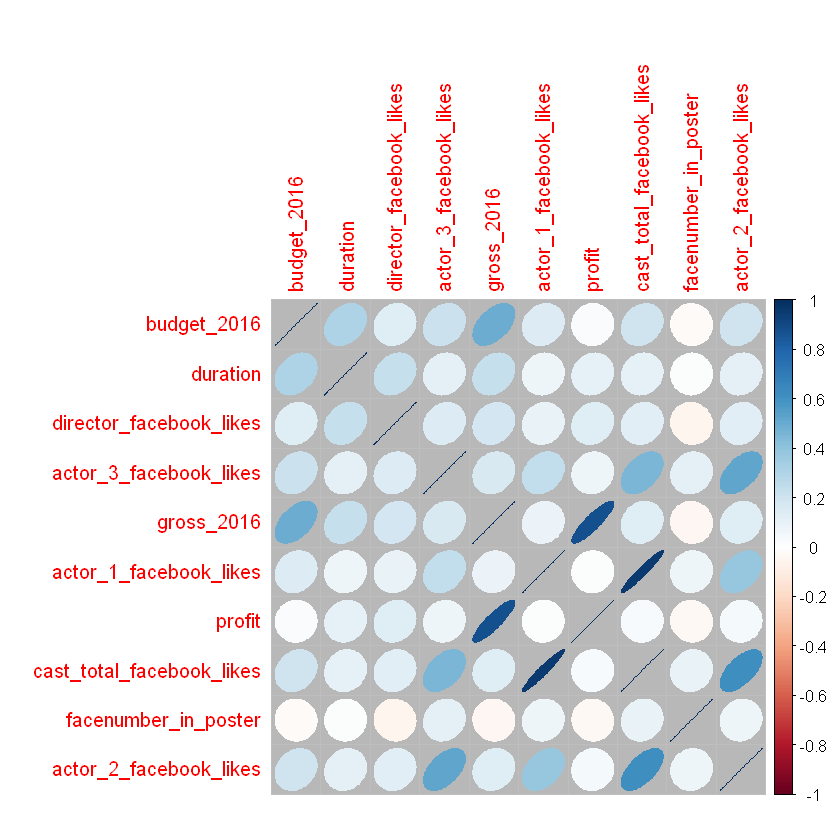

In [122]:
cont.var.corr.plot<-c("budget_2016","duration","director_facebook_likes","actor_3_facebook_likes","gross_2016",
                                   "actor_1_facebook_likes","profit","cast_total_facebook_likes","facenumber_in_poster",
                                   "actor_2_facebook_likes")
corr_movie<-cor(movies[,cont.var.corr.plot,with=FALSE], use = "na.or.complete")
#setkey(movies,NULL)
corrplot(corr_movie, method="ellipse", bg="#b8b8b8")

We can see that "budget_2016" and "duration" are the variables who are the more correlated with the value of the gross box-office and that those correlations are not really strong. The other variables have mild correlation with the variable "gross_2016" at best. The same thing can be said for the variable "profit" which have a correlation virtually null with all the other variables except "gross_2016", which make sense since "profit" is a linear combination of this variable and "budget_2016".

Next I plot the correlation matrix of the genre of each movie and the "profit" and "gross_2016" variables.

In [123]:
genre.var.corr.plot<-c("genres_Action","genres_Adventure","genres_Animation","genres_Biography","genres_Comedy",
                        "genres_Crime","genres_Documentary","genres_Drama","genres_Family","genres_Fantasy",
                        "genres_History","genres_Horror","genres_Music","genres_Musical","genres_Mystery",
                        "genres_News","genres_Romance","genres_Sci-Fi","genres_Short","genres_Sport",
                        "genres_Thriller","genres_War","genres_Western","gross_2016","profit")


corr_movie<-cor(movies[,genre.var.corr.plot,with=FALSE], use = "na.or.complete")
#setkey(movies,NULL)
corrplot(corr_movie, method="ellipse", bg="#b8b8b8")

ERROR: Error in `[.data.table`(movies, , genre.var.corr.plot, with = FALSE): column(s) not found: genres_Sci-Fi


Again, the "profit" and "gross_2016" variables have little to no correlation with the genre variables, except for the variable "genre_Adventure" who is positively correlated with the gross.

The last correlation matrix I plotted show the relation between the engineered variables "act_1_mean_gross", "act_2_mean_gross", "act_3_mean_gross", "dir_mean_gross", "gross_2016" and "profit".

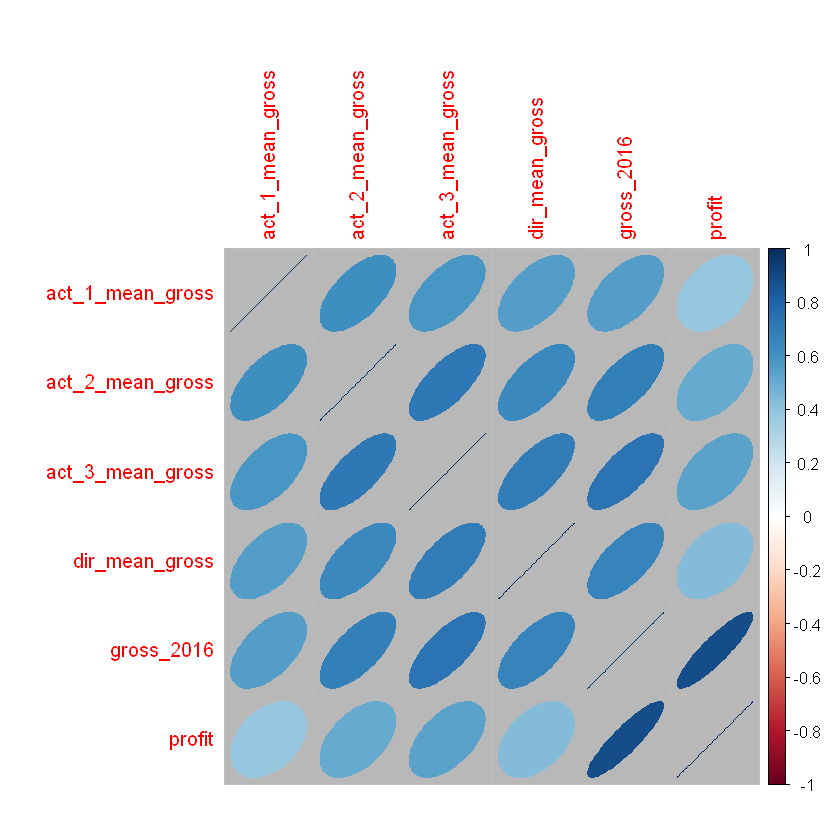

In [124]:
mean.gross.corr.plot<-c("act_1_mean_gross","act_2_mean_gross","act_3_mean_gross","dir_mean_gross","gross_2016","profit")


corr_movie<-cor(movies[,mean.gross.corr.plot,with=FALSE], use = "na.or.complete")
#setkey(movies,NULL)
corrplot(corr_movie, method="ellipse", bg="#b8b8b8")

This correlation matrix show that there's a strong correlation between the new variables and the "gross_2016" and "profit" variable. This can be explained in good part by the fact that the mean gross variables are a linear combination of the observations of the "gross_2016" variable and that most cast members have only a few movies in the data set. However, This result is a good indication that those new variables are a good feature to use in the model. To make sure that is the case and to avoid this source of bias, I will have to calculate the mean gross using only a fraction of the data set and calculate the correlation with the remaining observations. Since I have to separate the data in a training set and a test set and for brevity sake I just delete those variable of the data set and calculate the correlations in the next installment of that series of blog post.

In [125]:
movies<-movies[,!c("act_1_mean_gross","act_2_mean_gross","act_3_mean_gross","dir_mean_gross"),with=FALSE]

In [126]:
write.csv(movies,"movie_exploration.csv", col.names=TRUE)

Warning message in write.csv(movies, "movie_exploration.csv", col.names = TRUE):
"attempt to set 'col.names' ignored"

# Conclusion

The lack of correlation between the variable suggests that linear regression won't be the most effective way to modelize those data. A better way would be to use a decision tree to classify profitable and non-profitable movie. Also the engineered variables seem to be the best indicator of the profitability of a movie. That explains why movie stars are paid so much!

In the next part of this series, I'll use machine learning algorithms to predict if a movie will be profitable and see if we can make better predictions than the average Hollywood producer. 